In this notebook, I use TyXe and Pyro to implement VCL on CNNs. The dataset is split-Cifar dataset. 


The basic logic of pyro is to define a "model" representing the prior + likelihood, and a "guide" representing the posterior. Then VI will be executed automatically by SGD.

In [1]:
device = "cuda" 

## install packages

In [2]:
! pip install pyro-ppl
! git clone https://github.com/TyXe-BDL/TyXe.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'TyXe' already exists and is not an empty directory.


## Import Packages

In [3]:
%cd /content/TyXe

/content/TyXe


In [4]:
import os
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from torchvision.models import resnet18
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

import tyxe
import functools

import pyro
import pyro.nn as pynn
import pyro.poutine as poutine
from pyro import distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, MCMC

import pyro.infer.autoguide.initialization as ag_init


## Load data

In [5]:
import torch
from torch import nn
from torch.utils.data import random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os, tarfile
from torchvision import datasets

def get_split_notMNIST(task_idx, device, train, test):
    # "The notMNIST dataset contains 400,000 images of the characters from 
    #  A to J with different font styles. We consider ﬁve binary classiﬁcation 
    #  tasks: A/F, B/G, C/H, D/I, and E/J"

    labels = (task_idx, task_idx + 5) # labels are 0 to 9 for A to J in order
    ds_train_filtered = list(filter(lambda item: item[1] in labels, train))
    ds_test_filtered = list(filter(lambda item: item[1] in labels, test))
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train_filtered]))
    train_y = torch.tensor([0 if d[1] == task_idx else 1 for d in ds_train_filtered])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test_filtered]))
    test_y = torch.tensor([0 if d[1] == task_idx else 1 for d in ds_test_filtered])

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

def get_split_MNIST(task_idx, device, train, test):
    labels = np.array_split(range(0, 10), 5)[task_idx]
    train_filtered = list(filter(lambda item: item[1] in labels, train))
    test_filtered = list(filter(lambda item: item[1] in labels, test))
    train_x = nn.Flatten()(torch.cat([d[0] for d in train_filtered]))
    train_y = torch.tensor([d[1] - task_idx * 2 for d in train_filtered])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in test_filtered]))
    test_y = torch.tensor([d[1] - task_idx * 2 for d in test_filtered])

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

def get_split_CIFAR10(task_idx, device, train, test):
    labels = np.array_split(range(0, 10), 5)[task_idx]
    train_filtered = list(filter(lambda item: item[1] in labels, train))
    test_filtered = list(filter(lambda item: item[1] in labels, test))
    train_x = torch.cat([d[0][None, :, :, :] for d in train_filtered])
    train_y = torch.tensor([d[1] - task_idx * 2 for d in train_filtered])
    
    test_x = torch.cat([d[0][None, :, :, :] for d in test_filtered])
    test_y = torch.tensor([d[1] - task_idx * 2 for d in test_filtered])

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)


class MultiTaskDataset:
    def __init__(self, dataset_name: str, device: str):
        if dataset_name == 'split MNIST':
            self.train = datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
            self.test = datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
        elif dataset_name == 'split notMNIST':
            tar_file = './data/notMNIST_small.tar.gz'
            folder = './data/notMNIST_small'
            if not os.path.exists(folder):
                if not os.path.exists(tar_file):
                    raise Exception("notMNIST dataset is missing, download at: https://www.kaggle.com/datasets/lubaroli/notmnist")
                with tarfile.open(tar_file) as f:
                    f.extractall('./data/')
                assert os.path.exists(folder), "Something went wrong with extraction."

            # these are some empty images
            empty_files = ['A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png', 'F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png']
            for file_name in empty_files:
                file_name = f"{folder}/{file_name}"
                if os.path.exists(file_name):
                    os.remove(file_name)


            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()
            ])

            image_folder = ImageFolder(folder, transform=transform)

            # Same split ratio as in MNIST
            self.train, self.test = random_split(image_folder, [1 - 0.143, 0.143], generator=torch.Generator().manual_seed(0))
        elif dataset_name == 'split CIFAR-10':
            self.train = datasets.CIFAR10("./data", train=True, transform=transforms.ToTensor(), download=True)
            self.test = datasets.CIFAR10("./data", train=False, transform=transforms.ToTensor(), download=True)
        else:
            raise ValueError(f"Unknown dataset: {dataset_name}")
        
        self.dataset_name = dataset_name
        self.device = device
        
    def get_task_dataset(self, task_idx: int):
        if self.dataset_name == 'split MNIST':
            return get_split_MNIST(task_idx, self.device, self.train, self.test)
        elif self.dataset_name == 'split notMNIST':
            return get_split_notMNIST(task_idx, self.device, self.train, self.test)
        elif self.dataset_name == 'split CIFAR-10':
            return get_split_CIFAR10(task_idx, self.device, self.train, self.test)
        else:
            raise ValueError(f"Unknown dataset: {self.dataset_name}")

In [6]:
ds = MultiTaskDataset(dataset_name='split CIFAR-10', device=device)

Files already downloaded and verified
Files already downloaded and verified


## Define Networks and Likelihoods

In [7]:
# define a class, converting the network to a BNN distribution
class ModelBNN(pynn.PyroModule):
    def __init__(self, net, prior, name=""):
        super().__init__(name)
        self.net = net
        pynn.module.to_pyro_module_(self.net)
        self.prior = prior
        self.prior.apply_(self.net)
    def forward(self, *args, **kwargs):
        return self.net(*args, **kwargs)
    def update_prior(self, new_prior):
        self.prior = new_prior
        self.prior.update_(self)

In [8]:
# define the network here...
# I called it resnet because i am too lazy to change the name
# it can be any network 

class MultiHeadResnet(nn.Module):
    def __init__(self, head_nums):
        super().__init__()
        self.net = nn.Sequential()
        self.net.add_module("conv1", nn.Conv2d(3, 32, 3, padding=1))
        self.net.add_module("act1", nn.ReLU())
        self.net.add_module("conv2", nn.Conv2d(32, 32, 3, padding=1))
        self.net.add_module("act2", nn.ReLU())
        self.net.add_module("maxpool1", nn.MaxPool2d(2))
        self.net.add_module("conv3", nn.Conv2d(32, 64, 3, padding=1))
        self.net.add_module("act3", nn.ReLU())
        self.net.add_module("conv4", nn.Conv2d(64, 64, 3, padding=1))
        self.net.add_module("act4", nn.ReLU()) 
        self.net.add_module("maxpool2", nn.MaxPool2d(2))
        self.net.add_module("flatten", nn.Flatten())
        self.net.add_module("fc", nn.Linear(4096, 512))
        self.net.add_module("act5", nn.ReLU()) 

        self.heads = nn.ModuleList([nn.Linear(512, 2) for i in range(head_nums)])
    def forward(self, x):
        h = self.net(x)
        logits = torch.cat([i(h)[:, None, :] for i in self.heads], dim=1)
        return logits


In [9]:
def define_resnet():
    return MultiHeadResnet(5)

In [10]:
# define pyro model
def split_MNIST_model(multi_head_net, x, y, task_ids, dataset_size, annealing_factor):
    z = multi_head_net(x)[np.arange(x.shape[0]), task_ids, :] # reshape the last dimension into 5 heads
    with poutine.scale(None, dataset_size / x.shape[0]):
        with pyro.plate("batch_size", x.shape[0], dim=-1):
            pyro.sample("batch_obs", dist.Categorical(logits=z), obs=y.long())
    return z

In [11]:
def train_model(train_x, 
                train_y, 
                train_t, 
                batch_size,
                n_epochs,
                pyro_model,
                define_net, 
                last_guide, 
                random_init_guide,
                prior=tyxe.priors.IIDPrior(dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device)))):
    """
    a function to train BNN
    define_net: python callable, returning a torch nn network
    last_guide: if None, use prior; if not None, use it as prior
    prior: if last_guide is None. use this as the prior
    pyro_model: python callable, defining the pyro model
    """
    
    bnn = ModelBNN(define_net(), prior).to(device) # define the bnn model
    if last_guide != None:
        site_names = tyxe.util.pyro_sample_sites(bnn)
        bnn.update_prior(tyxe.priors.DictPrior(last_guide.get_detached_distributions(site_names)))
    opt = pyro.optim.ClippedAdam({"lr": 0.001}) 
    if random_init_guide or last_guide == None:
        guide = functools.partial(
                                  tyxe.guides.AutoNormal,  
                                  init_scale=1e-3,  
                                  init_loc_fn=ag_init.init_to_sample
                                 )(pyro_model)
    else:
        guide = deepcopy(last_guide)
    svi = SVI(pyro_model, guide, opt, Trace_ELBO())
    dataset_size = train_x.shape[0]


    pyro.clear_param_store()
    ELBO = []
    for epoch in tqdm(range(n_epochs)):
        elbos = []
        for batch in range(int(np.ceil(dataset_size / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            batch_x = train_x[batch_idx0: batch_idx1]
            batch_y = train_y[batch_idx0: batch_idx1]
            batch_t = train_t[batch_idx0: batch_idx1].long()
            elbo = svi.step(bnn, 
                            x=batch_x, 
                            y=batch_y, 
                            task_ids=batch_t, 
                            dataset_size=dataset_size, 
                            annealing_factor=1)
            elbos.append(elbo)
        ELBO.append(np.mean(elbos))
    return guide, ELBO


In [17]:
def prediction(test_x, 
               test_y,
               test_t, 
               define_net, 
               guide,
               n_particles=100):
    prior = tyxe.priors.IIDPrior(dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device)))
    bnn = ModelBNN(define_net(), prior).to(device) # define the bnn model
    site_names = tyxe.util.pyro_sample_sites(bnn)
    dist_dict = guide.get_detached_distributions(site_names)
    bnn.update_prior(tyxe.priors.DictPrior(dist_dict)) # use the guide as the prior

    pyro.clear_param_store()
    Z = []
    for _ in range(n_particles):  
        z = bnn(test_x)[np.arange(test_x.shape[0]), test_t, :]
        Z.append(z)
    pred = torch.stack(Z).mean(0).argmax(-1)
    acc = (pred == test_y).cpu().detach().numpy().mean()
    return acc

In [18]:
batch_size = 1000000
coreset_size = 40
coreset_x = None
coreset_y = None
coreset_t = None


Test_x = []
Test_y = []
Test_t = []

Accuracies = {}

=================== train task 0 ========================
Training set contains 10000 Images...


100%|██████████| 500/500 [05:38<00:00,  1.48it/s]


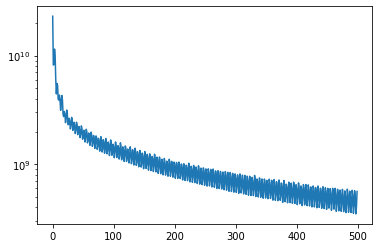

The Accuracies of Propogation Model
[0.8285]


100%|██████████| 500/500 [00:27<00:00, 17.93it/s]


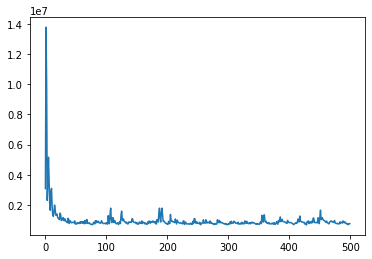

The Accuracies of Predict Model
[0.844]
=================== train task 1 ========================
Training set contains 10000 Images...


100%|██████████| 500/500 [05:38<00:00,  1.48it/s]


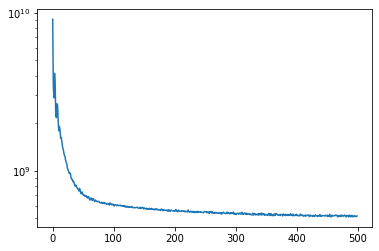

The Accuracies of Propogation Model
[0.649, 0.6935]


100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


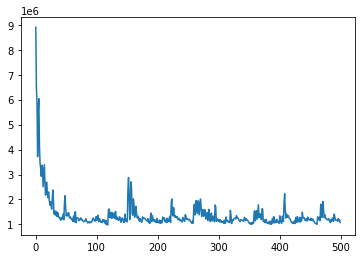

The Accuracies of Predict Model
[0.7875, 0.6735]
=================== train task 2 ========================
Training set contains 10000 Images...


100%|██████████| 500/500 [05:38<00:00,  1.48it/s]


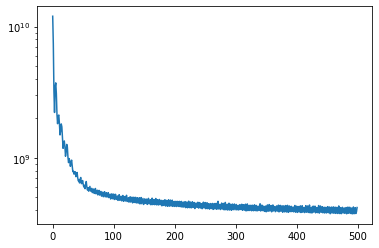

The Accuracies of Propogation Model
[0.5925, 0.5525, 0.729]


100%|██████████| 500/500 [00:28<00:00, 17.33it/s]


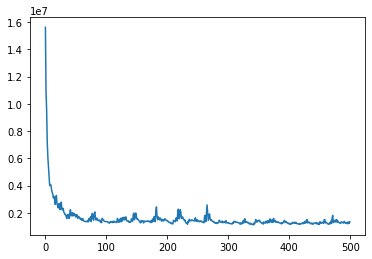

The Accuracies of Predict Model
[0.722, 0.622, 0.7]
=================== train task 3 ========================
Training set contains 10000 Images...


100%|██████████| 500/500 [05:37<00:00,  1.48it/s]


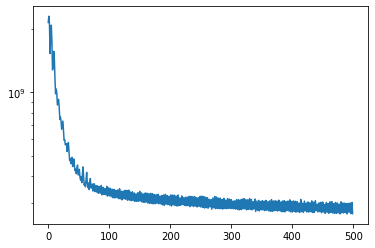

The Accuracies of Propogation Model
[0.6445, 0.534, 0.7015, 0.8065]


100%|██████████| 500/500 [00:28<00:00, 17.63it/s]


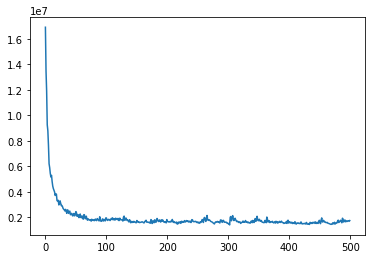

The Accuracies of Predict Model
[0.707, 0.6165, 0.672, 0.798]
=================== train task 4 ========================
Training set contains 10000 Images...


100%|██████████| 500/500 [05:36<00:00,  1.49it/s]


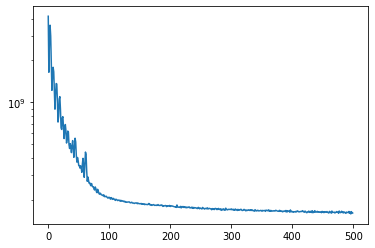

The Accuracies of Propogation Model
[0.6705, 0.5595, 0.5075, 0.6675, 0.8265]


100%|██████████| 500/500 [00:29<00:00, 16.90it/s]


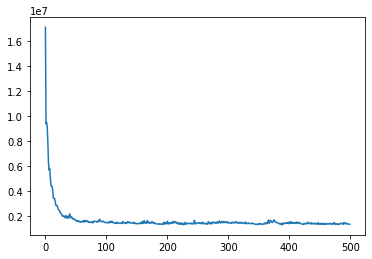

The Accuracies of Predict Model
[0.697, 0.612, 0.626, 0.73, 0.816]


In [19]:
for task_idx in range(5):
    print("=================== train task %d ========================"%task_idx)
    train_x, train_y, test_x, test_y = ds.get_task_dataset(task_idx)
    print("Training set contains %d Images..."%train_x.shape[0])
    train_x, train_y = train_x, train_y

    # select coreset
    ###############################################################
    # Modify the coreset selection approach below

    coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)


    # Modify the coreset selection approach above
    ###############################################################


    train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)

    Test_x.append(test_x)
    Test_y.append(test_y)
    Test_t.append(torch.ones_like(test_y) * task_idx)

    if coreset_x == None:
        coreset_x = train_x[coreset_idx]
        coreset_y = train_y[coreset_idx]
        coreset_t = torch.ones_like(train_y[coreset_idx]) * task_idx
    else:
        coreset_x = torch.cat([train_x[coreset_idx], coreset_x])
        coreset_y = torch.cat([train_y[coreset_idx], coreset_y])
        coreset_t = torch.cat([torch.ones_like(train_y[coreset_idx]) * task_idx, coreset_t])

    train_x = train_x[train_idx]
    train_y = train_y[train_idx]
    train_t = torch.ones_like(train_y) * task_idx

    prop_guide, ELBO = train_model(train_x, 
                                   train_y, 
                                   train_t, 
                                   batch_size,
                                   n_epochs=500,
                                   pyro_model=split_MNIST_model,
                                   define_net=define_resnet, 
                                   last_guide=prop_guide if task_idx != 0 else None,
                                   random_init_guide=True)
    plt.plot(ELBO)
    plt.yscale("log")
    plt.show()


    Acc = []
    for t in range(len(Test_x)):
        acc = prediction(test_x=Test_x[t], 
                         test_y=Test_y[t], 
                          test_t=Test_t[t], 
                          define_net=define_resnet, 
                          guide=prop_guide,
                          n_particles=100)
        Acc.append(acc)
    print("The Accuracies of Propogation Model")
    print(Acc)

    

    pred_guide, ELBO = train_model(coreset_x, 
                                   coreset_y, 
                                   coreset_t, 
                                   batch_size,
                                   n_epochs=500,
                                   pyro_model=split_MNIST_model,
                                   define_net=define_resnet, 
                                   last_guide=prop_guide,
                                   random_init_guide=False)
    plt.plot(ELBO)
    plt.show()


    Acc = []
    for t in range(len(Test_x)):
        acc = prediction(test_x=Test_x[t], 
                         test_y=Test_y[t], 
                         test_t=Test_t[t], 
                         define_net=define_resnet, 
                         guide=pred_guide,
                         n_particles=100)
        Acc.append(acc)
    print("The Accuracies of Predict Model")
    print(Acc)



In [ ]:
from google.colab import runtime
runtime.unassign()